<a href="https://colab.research.google.com/github/samsoe/mpg_notebooks/blob/master/gridVeg_survey_metadata_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# View: gridVeg_survey_effort
Project:Dataset in BQ: mpg-data-warehouse:vegetation_gridVeg_summaries.gridVeg_survey_effort

# Security
* The user must load a `json` file containing the BigQuery API key into the local directory `/content/...`
* The user must have a Google Maps API key to enable mapping. 
   * CAUTION make sure the key is deleted from the current instance of the notebook before sharing

# Tools
* Remember that the file containing authorization keys for Big Query must be loaded into the virutual envrionment manually.

In [ ]:
library(tidyverse)
library(knitr)
library(repr)
library(colorspace)

In [ ]:
install.packages("bigrquery")
library(bigrquery)

In [ ]:
if(!requireNamespace("devtools")) install.packages("devtools")
devtools::install_github("dkahle/ggmap", ref = "tidyup", force=TRUE)
# mapping
library("ggmap")

In [32]:
#@title Google Maps API key { vertical-output: true }
#@markdown Remember to delete the key from the input field 
#@markdown before sharing this file. Preferably, delete after 
#@markdown running this code and successfully authenticating.
key <- "" #@param {type:"string"}
register_google(key = key)
has_google_key()

[1] TRUE

# Functions and Styles
* Theme BGL for ggplot

In [6]:
# Theme BGL
# ————————————————————

theme_bgl = 
    theme_bw() +
    theme(
        axis.title = element_text(
            size = 12,
            family = "serif",
            face = 1
        ),
        axis.text.x = element_text(
            size = 9,
            family = "serif",
            face = 2,
            margin = unit(c(
                t = 3,
                r = 0,
                o = 0,
                b = 0
            ), "mm")
        ),
        axis.text.y = element_text(
            size = 9,
            family = "serif",
            face = 2,
            margin = unit(c(
                t = 0,
                r = 3,
                o = 0,
                b = 0
            ), "mm")
        ),
        axis.ticks.length = unit(-2, "mm"),
        strip.text = element_text(
            size = 12,
            family = "serif",
            face = 2
        ),
        plot.caption = element_text(
            size = 8,
            family = "serif",
            face = 2
        ),
        plot.title = element_text(
            size = 14,
            family = "serif",
            face = 2
        ),
        text = element_text(family = "serif"),
        legend.text = element_text(
            size = 12,
            family = "serif",
            face = 1
        ),
        legend.title = element_text(
            size = 12,
            family = "serif",
            face = 1
        ),
        legend.position = "right",
        panel.grid = element_blank()
    ) 

# Source

## Database Connection

In [7]:
# BigQuery API Key
bq_auth(path = "/content/mpg-data-warehouse-api_key-master.json")

In [8]:
Sys.setenv(BIGQUERY_TEST_PROJECT = "mpg-data-warehouse")

In [9]:
billing <- bq_test_project()

In [12]:
con_survey_effort <- dbConnect(
  bigrquery::bigquery(),
  project = "mpg-data-warehouse",
  dataset = "vegetation_gridVeg_summaries",
  billing = billing
)

In [13]:
dbListTables(con_survey_effort)

[1] "gridVeg_survey_effort"

In [14]:
survey_sql <- "SELECT *
               FROM `mpg-data-warehouse.vegetation_gridVeg_summaries.gridVeg_survey_effort`"

In [15]:
bq_survey <- bq_project_query(billing, survey_sql)

In [16]:
tb_survey <- bq_table_download(bq_survey)

In [17]:
df_survey <- as.data.frame(tb_survey)

In [18]:
str(df_survey)

'data.frame':	1245 obs. of  6 variables:
 $ grid_point                 : int  1 2 3 4 5 6 7 8 9 11 ...
 $ year                       : int  2011 2011 2011 2011 2011 2011 2011 2011 2011 2011 ...
 $ lat                        : num  46.7 46.7 46.7 46.7 46.7 ...
 $ long                       : num  -114 -114 -114 -114 -114 ...
 $ cover_type_2016_gridVeg    : chr  "woodland/forest" "non-irrigated grasslands" "shrubland" "shrubland" ...
 $ type3_vegetation_indicators: chr  "mixed canopy conifer" "uncultivated grassland native or degraded" "uncultivated grassland native or degraded" "uncultivated grassland native or degraded" ...


# Data Visualization

Source : https://maps.googleapis.com/maps/api/staticmap?center=46.700006,-114.008&zoom=13&size=640x640&scale=2&maptype=terrain&key=xxx



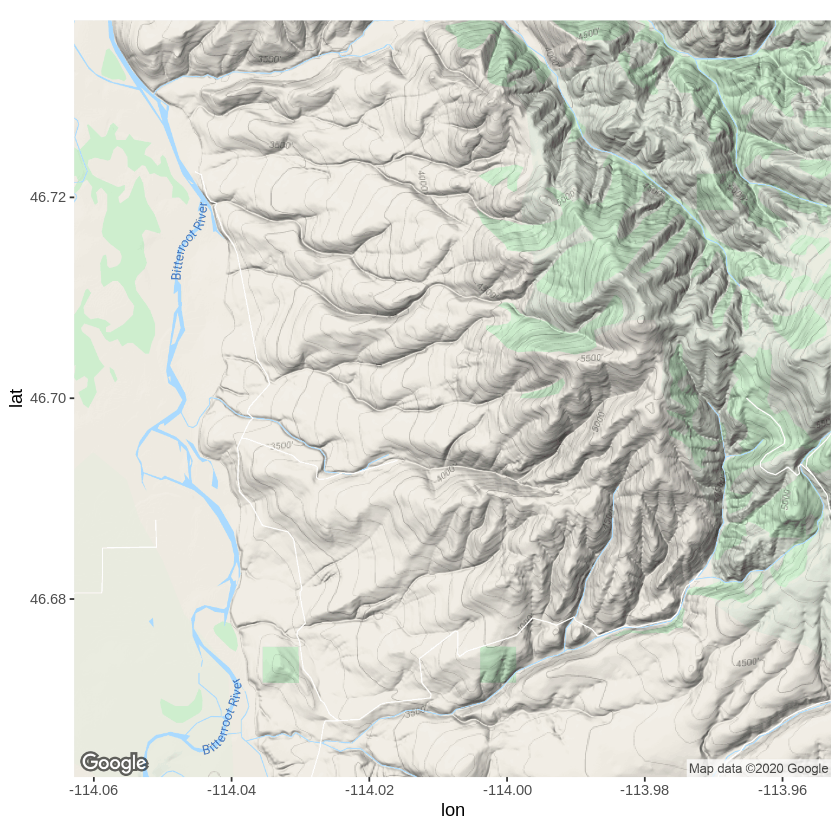

In [35]:
mpgr_map <- ggmap(get_googlemap(center = c(lon = -114.008, lat = 46.700006),
                                zoom = 13, scale = 2,
                                maptype ='terrain',
                                color = 'color')
                                )
mpgr_map                      

In [56]:
func_colsum <- function(z) if (is.numeric(z)) {
    sum(z, na.rm = TRUE)
  } else {
    "Total"
}

survey_table <- df_survey %>%
  group_by(year, type3_vegetation_indicators) %>%
  summarize(count = n(), .groups = 'drop') %>%
  spread(year, count) %>%
  as.data.frame()

survey_table_colsum <- df_survey %>%
  group_by(year, type3_vegetation_indicators) %>%
  summarize(count = n(), .groups = 'drop') %>%
  spread(year, count) %>%
  sapply(., FUN = func_colsum) %>%
  t() %>%
  as.data.frame()

rbind(survey_table, survey_table_colsum) %>% 
  kable(format = "pandoc", caption = "Survey effort across years and habitats")



Table: Survey effort across years and habitats

type3_vegetation_indicators                 2011   2012   2013   2015   2016   2017 
------------------------------------------  -----  -----  -----  -----  -----  -----
bitterbrush                                 26     4      3      3      30     NA   
closed canopy conifer                       5      4      NA     NA     9      NA   
former cultivated                           63     44     4      NA     106    NA   
mixed canopy conifer                        25     84     1      NA     108    4    
mixed sage and bitterbrush                  82     11     7      35     92     NA   
open canopy conifer                         1      20     NA     NA     21     2    
other shrub deciduous                       4      4      NA     NA     8      NA   
riparian woodland                           16     6      4      NA     21     NA   
sagebrush                                   13     4      1      2      17     NA   
uncultivated gr

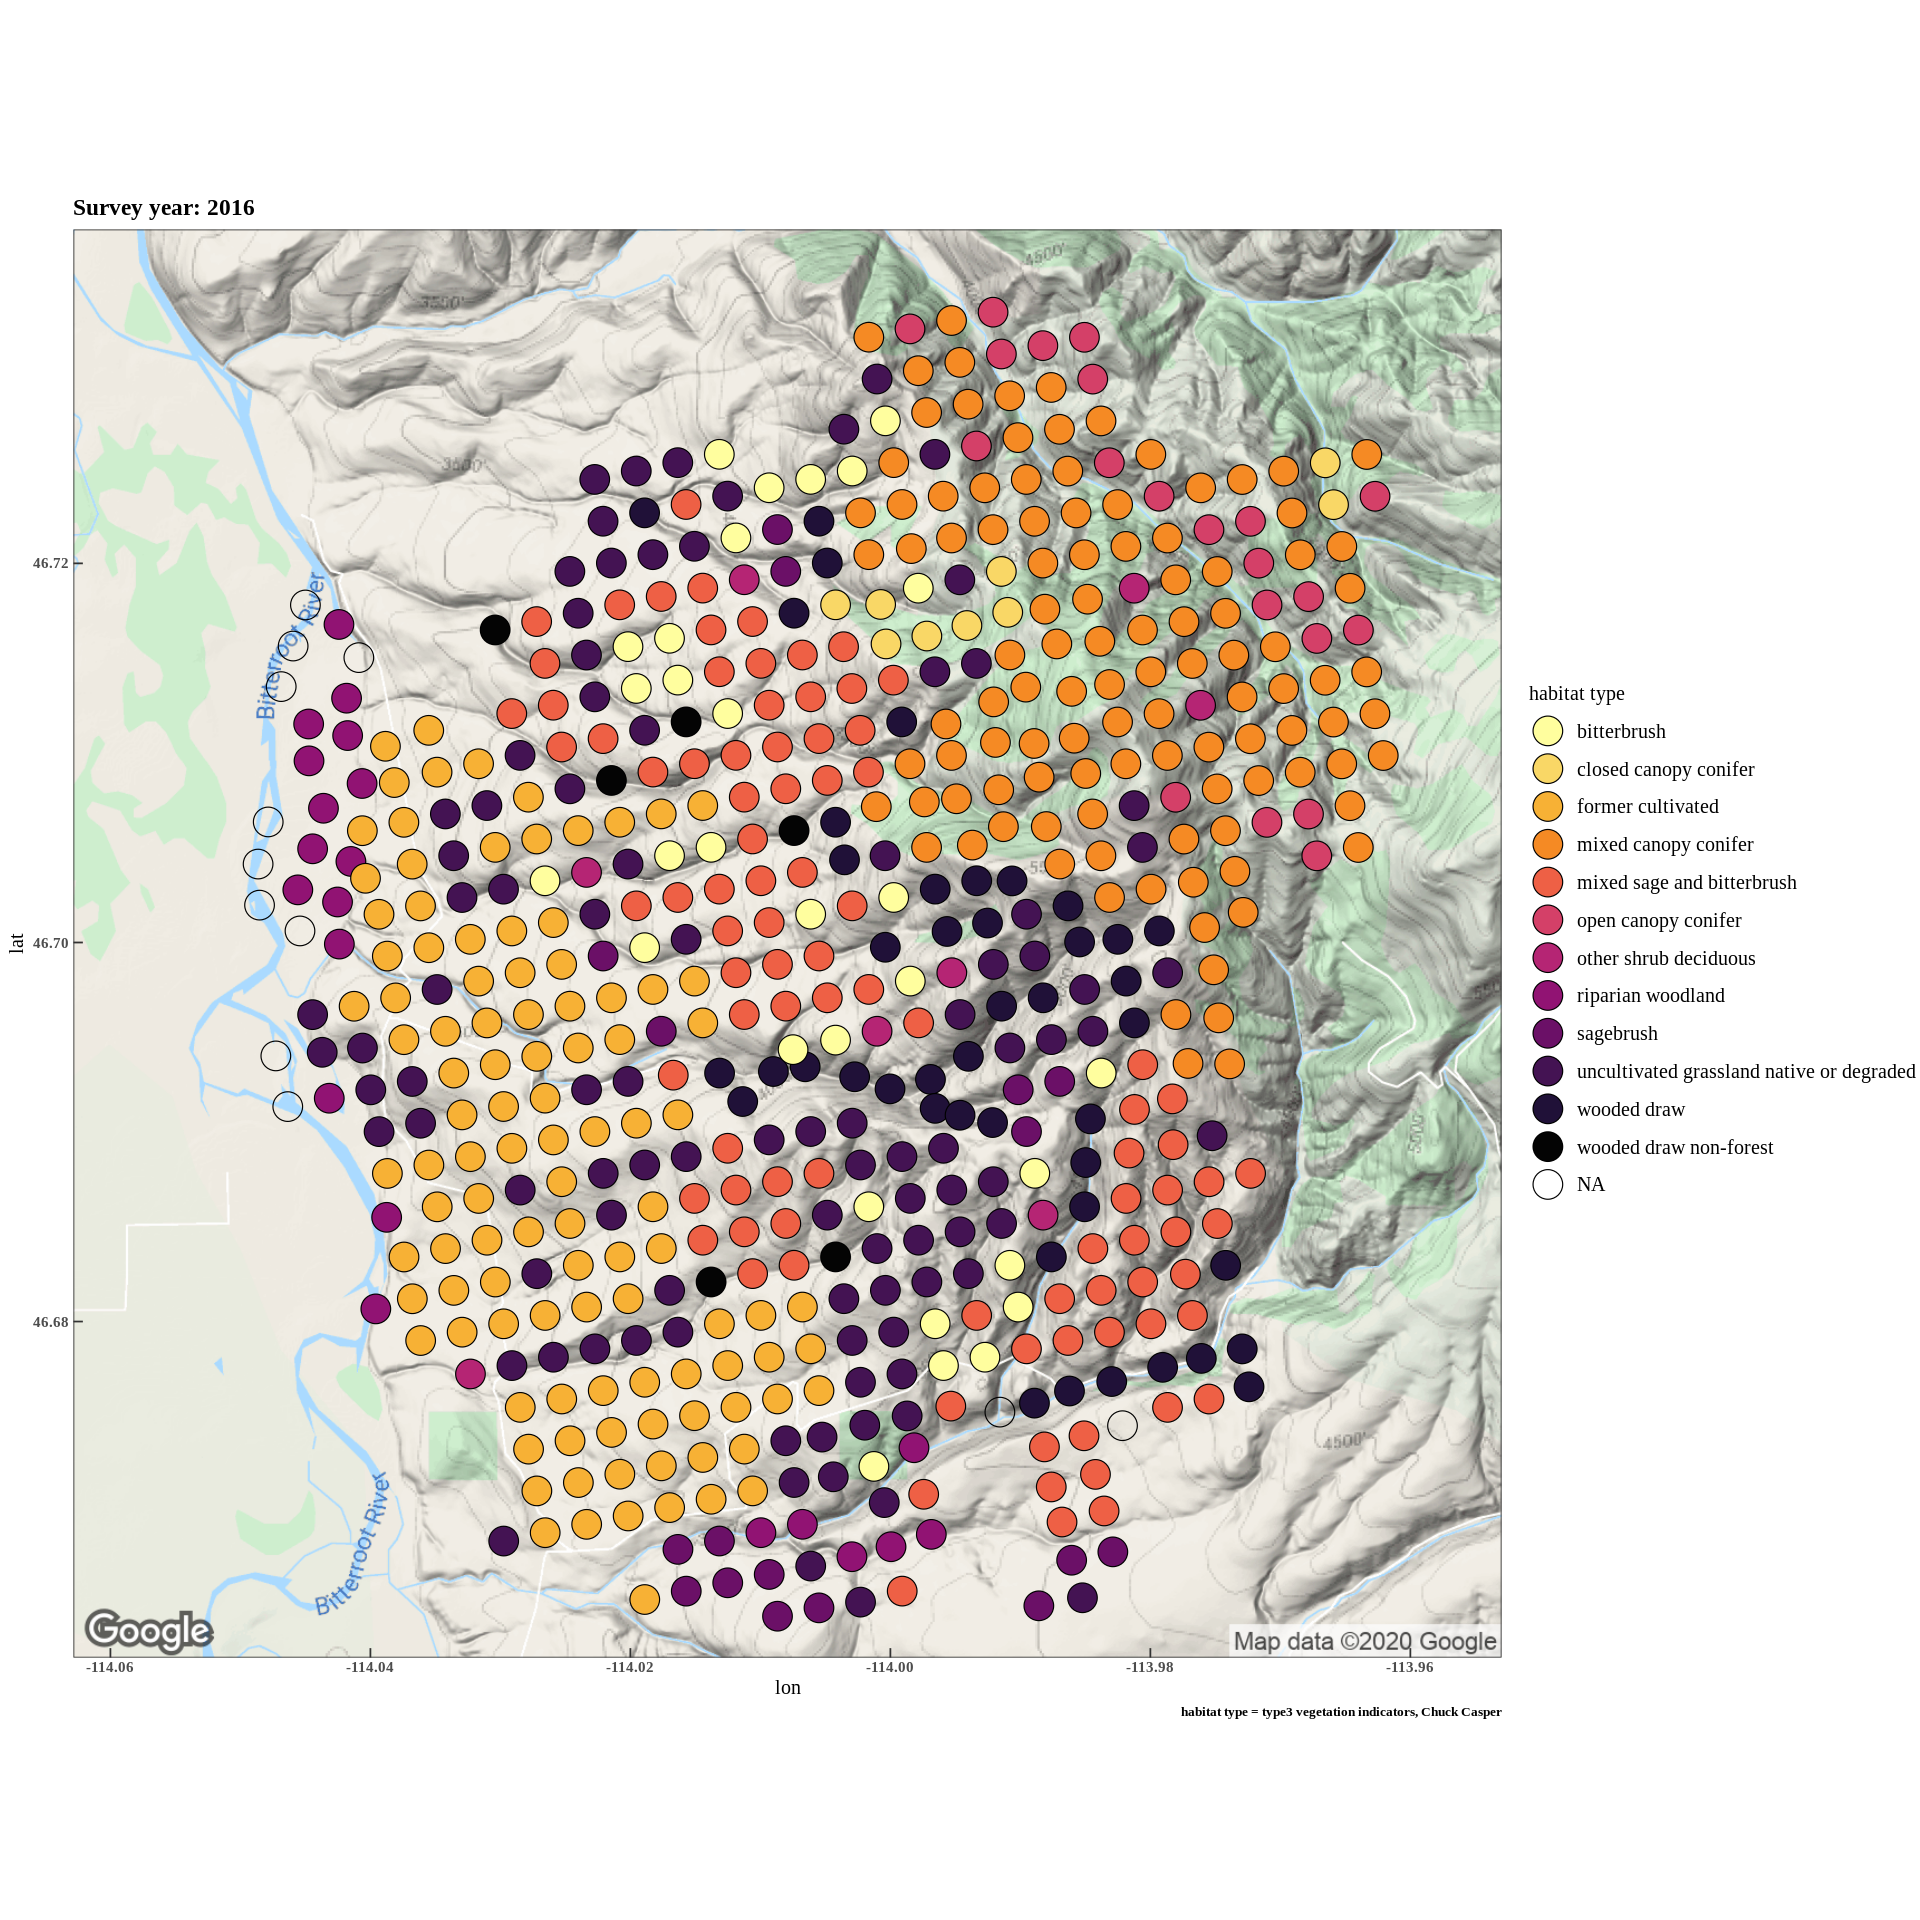

In [84]:
#@title Survey effort maps { run: "auto" }
#@markdown Type a year into the field below. Surveys began in 2010
selected_year <- 2016 #@param {type:"integer"}

# Plot of selected year
options(repr.plot.width = 16, repr.plot.height = 16)
mpgr_map +
  geom_point(data = df_survey %>% filter(year == selected_year), 
              aes(x = long, y = lat, fill = type3_vegetation_indicators), 
              size = 8, shape = 21) +
  labs(title = paste("Survey year:", selected_year),
        fill = "habitat type",
        caption = "habitat type = type3 vegetation indicators, Chuck Casper") +
  scale_fill_discrete_sequential(palette = "Inferno") +
  theme_bgl